# Dataset Assembly: Comprehensive Ancient Egyptian Corpus

This notebook scrapes, cleans, and assembles a comprehensive dataset of Ancient Egyptian hieroglyphic texts.

## Goals
1. Collect data from TLA (and potentially other sources)
2. Clean and normalize transliterations
3. Deduplicate across sources
4. Generate quality statistics
5. Export final corpus for model training

In [2]:
import sys
sys.path.append('../scrapers')

import json
import pandas as pd
from pathlib import Path
from collections import Counter
import re
from tqdm import tqdm

## 1. Data Collection

Run the TLA scraper to collect our base dataset.

In [3]:
from tla_scraper import TLAScraper

print("Scraping TLA dataset...")
tla_scraper = TLAScraper()
tla_data = tla_scraper.scrape()
tla_scraper.save_results(tla_data, "tla_raw.json")

print(f"\nCollected {len(tla_data)} texts from TLA")
print("\nScraping Ramses dataset...")
from ramses_scraper import RamsesScraper
ramses_scraper = RamsesScraper()
# Check if file already exists to avoid re-scraping if not needed
if not (Path('data/raw/ramses_raw.json').exists()):
    print("Running Ramses scraper (limit=100 for demo)...")
    ramses_data = ramses_scraper.scrape(max_texts=100)
    ramses_scraper.save_results(ramses_data, "ramses_raw.json")
else:
    print("Ramses data already exists, skipping scrape.")
    with open('data/raw/ramses_raw.json', 'r', encoding='utf-8') as f:
        ramses_data = json.load(f)

print(f"Collected {len(ramses_data)} texts from Ramses")

Scraping TLA dataset...
Loading TLA dataset from HuggingFace...
Loaded 12773 texts from HuggingFace
Saved 12773 records to data/raw/tla_raw.json

Collected 12773 texts from TLA

Scraping Ramses dataset...
Ramses data already exists, skipping scrape.
Collected 9644 texts from Ramses


## 2. Load and Inspect Data

In [4]:
# Load the scraped data
tla_path = Path('data/raw/tla_raw.json')
ramses_path = Path('data/raw/ramses_raw.json')

data = []

if tla_path.exists():
    with open(tla_path, 'r', encoding='utf-8') as f:
        tla_data = json.load(f)
        print(f"Loaded {len(tla_data)} records from TLA")
        data.extend(tla_data)

if ramses_path.exists():
    with open(ramses_path, 'r', encoding='utf-8') as f:
        ramses_data = json.load(f)
        print(f"Loaded {len(ramses_data)} records from Ramses")
        data.extend(ramses_data)


print("\nLoading BBAW dataset...")
bbaw_path = Path('../data/raw/bbaw_huggingface.parquet')

if bbaw_path.exists():
    bbaw_df = pd.read_parquet(bbaw_path)
    print(f"Loaded {len(bbaw_df)} records from BBAW")
    
    # Map columns to match our schema
    # transcription -> transliteration
    # translation -> translation
    # hieroglyphs -> hieroglyphs (new column to preserve)
    
    bbaw_formatted = []
    for _, row in bbaw_df.iterrows():
        record = {
            'transliteration': row['transcription'] if row['transcription'] else "",
            'translation': row['translation'] if row['translation'] else "",
            'source': 'BBAW (HuggingFace)',
            'metadata': {'hieroglyphs': row['hieroglyphs']} if row['hieroglyphs'] else {}
        }
        # Also keep hieroglyphs as a top-level column if we want to use it later easily
        # But for now, putting it in metadata or a separate column in the dataframe is fine.
        # Let's actually add it to the main list and let the dataframe handle the extra column.
        record['hieroglyphs'] = row['hieroglyphs']
        bbaw_formatted.append(record)
        
    data.extend(bbaw_formatted)
    print(f"Added {len(bbaw_formatted)} records from BBAW")
else:
    print(f"BBAW file not found at {bbaw_path}")


df = pd.DataFrame(data)
print(f"\nTotal combined records: {len(df)}")
print(f"Source distribution:\n{df['source'].value_counts()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few records:")
df.head()

Loaded 12773 records from TLA
Loaded 9644 records from Ramses

Loading BBAW dataset...
Loaded 100736 records from BBAW
Added 100736 records from BBAW

Total combined records: 123153
Source distribution:
source
BBAW (HuggingFace)    100736
TLA (HuggingFace)      12773
Ramses Online           9644
Name: count, dtype: int64

Columns: ['transliteration', 'translation', 'source', 'metadata', 'hieroglyphs']

First few records:


,transliteration,translation,source,metadata,hieroglyphs
0,nḏ (w)di̯ r =s,,TLA (HuggingFace),"{'text_id': '', 'period': 'Earlier Egyptian'}",NaN
1,n ṯw ꞽm =sn,,TLA (HuggingFace),"{'text_id': '', 'period': 'Earlier Egyptian'}",NaN
2,ḫꜣ m tʾ ḥnq.t kꜣ(.PL) ꜣpd(.PL) n ꞽmꜣḫ ꞽm.ꞽ-rʾ-...,,TLA (HuggingFace),"{'text_id': '', 'period': 'Earlier Egyptian'}",NaN
3,ꜥḥꜥ,,TLA (HuggingFace),"{'text_id': '', 'period': 'Earlier Egyptian'}",NaN
4,(w)sꞽr wnꞽs m n =k ꞽr.t-ḥr.w ꞽꜥb n =k s(ꞽ) ꞽr ...,,TLA (HuggingFace),"{'text_id': '', 'period': 'Earlier Egyptian'}",NaN


In [4]:
# Check for missing data
print("Missing values:")
print(df.isnull().sum())

print(f"\nEmpty transliterations: {(df['transliteration'] == '').sum()}")
print(f"Empty translations: {(df['translation'] == '').sum()}")

Missing values:
transliteration        0
translation            0
source                 0
metadata               0
hieroglyphs        22424
dtype: int64

Empty transliterations: 7
Empty translations: 12804


## 3. Data Cleaning

Clean and normalize the hieroglyphic transliterations.

In [5]:
def clean_transliteration(text):
    """
    Clean hieroglyphic transliteration:
    - Remove extra whitespace
    - Normalize special characters
    - Keep only valid transliteration characters
    """
    if not isinstance(text, str):
        return ""
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Convert to lowercase for consistency
    text = text.lower()
    
    return text.strip()

# Apply cleaning
df['transliteration_clean'] = df['transliteration'].apply(clean_transliteration)

# Remove empty entries
df = df[df['transliteration_clean'] != '']

print(f"After cleaning: {len(df)} records")
print(f"\nSample cleaned transliterations:")
for i in range(min(5, len(df))):
    print(f"  {df.iloc[i]['transliteration_clean'][:80]}...")

After cleaning: 123141 records

Sample cleaned transliterations:
  nḏ (w)di̯ r =s...
  n ṯw ꞽm =sn...
  ḫꜣ m tʾ ḥnq.t kꜣ(.pl) ꜣpd(.pl) n ꞽmꜣḫ ꞽm.ꞽ-rʾ-šnꜥ.pl ꞽmn-m-ḥꜣ.t mꜣꜥ-ḫrw...
  ꜥḥꜥ...
  (w)sꞽr wnꞽs m n =k ꞽr.t-ḥr.w ꞽꜥb n =k s(ꞽ) ꞽr rʾ =k...


## 4. Deduplication

Remove duplicate texts to ensure dataset quality.

In [7]:
print(f"Before deduplication: {len(df)} records")

# Remove exact duplicates based on transliteration
df_dedup = df.drop_duplicates(subset=['transliteration_clean'], keep='first')

print(f"After deduplication: {len(df_dedup)} records")
print(f"Removed {len(df) - len(df_dedup)} duplicates")

Before deduplication: 123141 records
After deduplication: 104426 records
Removed 18715 duplicates


## 5. Dataset Statistics

Generate comprehensive statistics about our corpus.

In [8]:
# Calculate statistics
stats = {
    'total_texts': len(df_dedup),
    'total_words': df_dedup['transliteration_clean'].str.split().str.len().sum(),
    'avg_words_per_text': df_dedup['transliteration_clean'].str.split().str.len().mean(),
    'median_words_per_text': df_dedup['transliteration_clean'].str.split().str.len().median(),
    'min_words': df_dedup['transliteration_clean'].str.split().str.len().min(),
    'max_words': df_dedup['transliteration_clean'].str.split().str.len().max()
}

print("=== Dataset Statistics ===")
for key, value in stats.items():
    print(f"{key}: {value:,.2f}" if isinstance(value, float) else f"{key}: {value:,}")

=== Dataset Statistics ===
total_texts: 104,426
total_words: 872,070
avg_words_per_text: 8.35
median_words_per_text: 6.00
min_words: 1
max_words: 276


In [9]:
# Word frequency analysis
all_words = ' '.join(df_dedup['transliteration_clean']).split()
word_freq = Counter(all_words)

print(f"\nUnique words: {len(word_freq):,}")
print(f"\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count:,}")


Unique words: 85,013

Top 20 most common words:
  n: 37,474
  =f: 37,217
  m: 32,387
  =k: 26,900
  ḥr: 14,274
  r: 13,849
  =j: 13,735
  jw: 10,211
  1: 7,030
  pꜣ: 6,536
  =s: 5,847
  =sn: 5,735
  nb: 5,408
  tꜣ: 4,429
  2: 4,409
  sw: 3,982
  pw: 3,708
  n(,j): 3,657
  jr: 3,647
  jm: 3,530


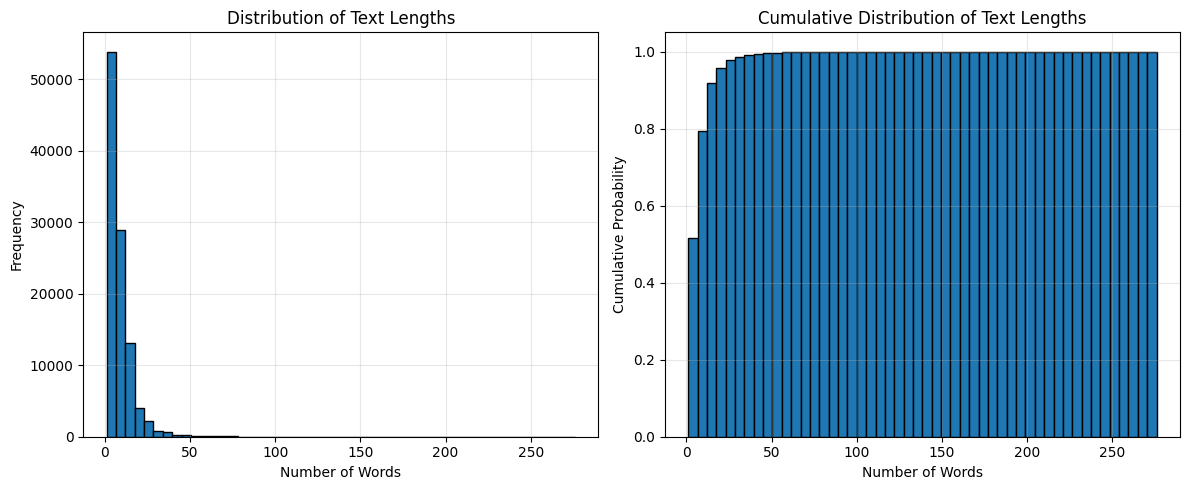

Saved visualization to data/processed/text_length_distribution.png


In [10]:
# Text length distribution
import matplotlib.pyplot as plt

text_lengths = df_dedup['transliteration_clean'].str.split().str.len()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(text_lengths, bins=50, edgecolor='black', cumulative=True, density=True)
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Text Lengths')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved visualization to data/processed/text_length_distribution.png")

## 6. Export Final Corpus

Save the cleaned, deduplicated corpus in multiple formats.

In [11]:
# -------------------------------------------------
# Imports – make sure these are at the top of the notebook
# -------------------------------------------------
import json
from pathlib import Path
import pandas as pd

# -------------------------------------------------
# Assume you already have a DataFrame called `df_dedup`
# that contains a column `transliteration_clean`
# and a dictionary `stats` with whatever statistics you want
# -------------------------------------------------
# Example (remove if you already have them):
# df_dedup = df.copy()                     # your deduplicated DataFrame
# df_dedup['transliteration_clean'] = df_dedup['transliteration'].str.strip()
# stats = {
#     "total_records": len(df_dedup),
#     "unique_transliterations": df_dedup['transliteration_clean'].nunique(),
# }

# -------------------------------------------------
# 1️⃣ Create the output directory
# -------------------------------------------------
output_dir = Path('data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# 2️⃣ Plain‑text corpus (one sentence per line)
# -------------------------------------------------
corpus_file = output_dir / 'hieroglyphic_corpus.txt'
with corpus_file.open('w', encoding='utf-8') as f:
    for text in df_dedup['transliteration_clean']:
        f.write(text + '\n')
print(f"✅ Saved plain‑text corpus: {corpus_file}")

# -------------------------------------------------
# 3️⃣ TSV with full metadata
# -------------------------------------------------
tsv_file = output_dir / 'hieroglyphic_corpus_full.tsv'
df_dedup.to_csv(tsv_file, sep='\t', index=False, encoding='utf-8')
print(f"✅ Saved TSV with metadata: {tsv_file}")

# -------------------------------------------------
# 4️⃣ JSON for programmatic access
# -------------------------------------------------
json_file = output_dir / 'hieroglyphic_corpus.json'
df_dedup.to_json(json_file, orient='records', force_ascii=False, indent=2)
print(f"✅ Saved JSON: {json_file}")

# -------------------------------------------------
# 5️⃣ Statistics summary (as JSON)
# -------------------------------------------------
def _make_json_serializable(obj):
    """
    Recursively convert NumPy/Pandas scalars (int64, float64, etc.)
    to native Python types for JSON serialization.
    """
    if isinstance(obj, (list, tuple)):
        return [_make_json_serializable(o) for o in obj]
    if isinstance(obj, dict):
        return {k: _make_json_serializable(v) for k, v in obj.items()}
    # Handle NumPy/Pandas scalars
    if hasattr(obj, "item"):
        return obj.item()
    return obj

# -------------------------------------------------
# 5️⃣ Statistics summary (as JSON)
# -------------------------------------------------
stats_file = output_dir / 'corpus_statistics.json'

# Convert the dict to pure Python types
serializable_stats = _make_json_serializable(stats)

with stats_file.open('w', encoding='utf-8') as f:
    json.dump(serializable_stats, f, indent=2, ensure_ascii=False)

print(f"✅ Saved statistics: {stats_file}")

✅ Saved plain‑text corpus: data/processed/hieroglyphic_corpus.txt
✅ Saved TSV with metadata: data/processed/hieroglyphic_corpus_full.tsv
✅ Saved JSON: data/processed/hieroglyphic_corpus.json
✅ Saved statistics: data/processed/corpus_statistics.json


## 7. Quality Check

Final validation of the corpus.

In [12]:
print("=== Final Corpus Summary ===")
print(f"Total unique texts: {len(df_dedup):,}")
print(f"Total words: {stats['total_words']:,.0f}")
print(f"Unique vocabulary: {len(word_freq):,}")
print(f"Average text length: {stats['avg_words_per_text']:.1f} words")
print(f"\nFiles saved to: {output_dir.absolute()}")
print("\n✅ Dataset assembly complete!")

=== Final Corpus Summary ===
Total unique texts: 104,426
Total words: 872,070
Unique vocabulary: 85,013
Average text length: 8.4 words

Files saved to: /Users/crashy/Development/heiroglyphy/ramses_data_scrape/notebooks/data/processed

✅ Dataset assembly complete!
